In [0]:
import pandas as pd
import numpy as np
from collections import Counter

In [0]:
from multiprocessing.dummy import Pool
import concurrent.futures
import multiprocessing
import tqdm

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [0]:
import gensim
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [0]:
model = gensim.models.KeyedVectors.load('/content/drive/My Drive/mailClassifier/fasttext_v2/model.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
fastext_vocab = set(model.wv.vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [0]:
df = pd.read_csv('/content/drive/My Drive/mailClassifier/mail_lemmatized_FULL_v2.csv', encoding = 'utf-8-sig')
df = df.drop('Unnamed: 0', 1)
df = df.fillna('')
df = df[df['content']!='']
df = df[df['category']!='WAP сайты']

df['titledesc'] = df[['title','description']].apply(lambda row: ' '.join(row),axis=1)
df = df[df['titledesc']!='']

Создание датасета категорий (df_categs)

In [0]:
df_categs = df[['category','titledesc','content']]
df_categs = df_categs[df_categs['titledesc']!='']

In [0]:
dict_categs = {}
dict_categsINV = {}
categs = list(set(df_categs['category']))

for i in range(17):
  dict_categs[i] = categs[i]

for i in range(17):
  dict_categsINV[categs[i]] = i

In [0]:
dict_categs

{0: 'Наука/Техника/Образование',
 1: 'Справки',
 2: 'Вокруг света',
 3: 'Карьера/работа',
 4: 'Интернет',
 5: 'Непознанное',
 6: 'Культура/Искусство',
 7: 'Авто/мото',
 8: 'Спорт',
 9: 'Предприятия',
 10: 'Государство Российское',
 11: 'Компьютеры',
 12: 'Домашний очаг',
 13: 'Юмор',
 14: 'СМИ',
 15: 'Отдых',
 16: 'Деловой мир'}

In [0]:
df_categs = df_categs.replace({'category': dict_categsINV})

Создание датасета подкатегорий (df_subcategs)

In [0]:
df_subcategs = df[['subcategory','titledesc','content']]
df_subcategs = df_subcategs[df_subcategs['titledesc']!='']

In [0]:
subcateg_counts = df_subcategs.groupby(['subcategory']).size().reset_index(name='counts').sort_values(by=['counts'])
indeed_subcategs = set(subcateg_counts[subcateg_counts['counts']>=500]['subcategory'])

In [0]:
df_subcategs = df_subcategs[df_subcategs['subcategory'].isin(indeed_subcategs)]

In [0]:
df_subcategs = df_subcategs.rename(columns={'subcategory':'category'})

In [0]:
df_subcategs = df_subcategs.reset_index(drop=True)

In [0]:
dict_subcategs = {}
dict_subcategsINV = {}
subcategs = list(set(df_subcategs['category']))

for i in range(len(subcategs)):
  dict_subcategs[i] = subcategs[i]

for i in range(len(subcategs)):
  dict_subcategsINV[subcategs[i]] = i

In [0]:
df_subcategs = df_subcategs.replace({'category': dict_subcategsINV})

In [0]:
dict_subcategs

{0: 'Запчасти',
 1: 'Общение с природой',
 2: 'Гардероб',
 3: 'Сельскохозяйственное производство',
 4: 'Футбол',
 5: 'Неправительственные организации',
 6: 'Торговля',
 7: 'Безопасность',
 8: 'Домашний доктор',
 9: 'Специализированный софт',
 10: 'Электронная коммерция',
 11: 'Железо',
 12: 'Личная жизнь',
 13: 'Фильмы, аудиокниги, игры',
 14: 'Путешествия',
 15: 'Усадьба',
 16: 'Хозяйка',
 17: 'Услуги, сервис',
 18: 'Эзотерика',
 19: 'Журналы',
 20: 'Аудит и бухучет',
 21: 'Деревообработка и целлюлозно-бумажные производства',
 22: 'Научные издания и публикации',
 23: 'Курорты',
 24: 'Производство строительных материалов',
 25: 'Умелые руки',
 26: 'Обозрения',
 27: 'Стройматериалы и строительство',
 28: 'Транспорт',
 29: 'Политика',
 30: 'Консультирование, правовая поддержка бизнеса',
 31: 'Фотоискусство',
 32: 'Активный отдых',
 33: 'Здоровье',
 34: 'Студенческая жизнь',
 35: 'Творческие, общественные объединения',
 36: 'Интернет-услуги',
 37: 'Абитуриенту и первокласснику',
 38: 'Шоу

**Вспомогательные функции**

In [0]:
def FindMCWordsByCategory(ourdf, numberTitle, numberContent):
  dfgroups_content = ourdf[['category','content']].groupby('category')['content'].apply(lambda row: ' '.join(row))
  dfgroups_title = ourdf[['category','titledesc']].groupby('category')['titledesc'].apply(lambda row: ' '.join(row))
  mostCW_content = []
  mostCW_title = []
  for i in range(len(dfgroups_content)):
    counter1 = Counter(dfgroups_content[i].split())
    most_occur = counter1.most_common(numberContent)
    mostCW = [ocur[0] for ocur in most_occur]
    mostCW_content.extend(mostCW)

    counter2 = Counter(dfgroups_title[i].split())
    most_occur = counter2.most_common(numberTitle)
    mostCW = [ocur[0] for ocur in most_occur]
    mostCW_title.extend(mostCW)

  return mostCW_title, mostCW_content

def FindMCWords(ourdf, numberTitle, numberContent):
  
  corpusstr = ' '.join(ourdf['content'])
  counter1 = Counter(corpusstr.split())
  most_occur = counter1.most_common(numberContent)
  mostCW = [ocur[0] for ocur in most_occur]
  
  mostCW_content = mostCW

  corpusstr = ' '.join(ourdf['titledesc'])
  counter1 = Counter(corpusstr.split())
  most_occur = counter1.most_common(numberTitle)
  mostCW = [ocur[0] for ocur in most_occur]

  mostCW_title = mostCW

  return mostCW_title, mostCW_content

In [0]:
def SelectWords(text):
  tokens = text.split()
  tokens = [token for token in tokens if token in WordsToSelect and token in fastext_vocab]
  
  return ' '.join(tokens)

def DeleteWords(text):
  tokens = text.split()
  tokens = [token for token in tokens if token not in WordsToDelete]
  
  return ' '.join(tokens)

График колличества сайтов на категорию в df_categs (датасете по категориям)

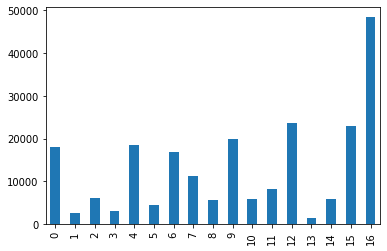

In [0]:
df_categs.groupby(['category']).size().reset_index(name='counts')['counts'].plot.bar()

График колличества сайтов на категорию в df_subcategs (датасете по подкатегориям)

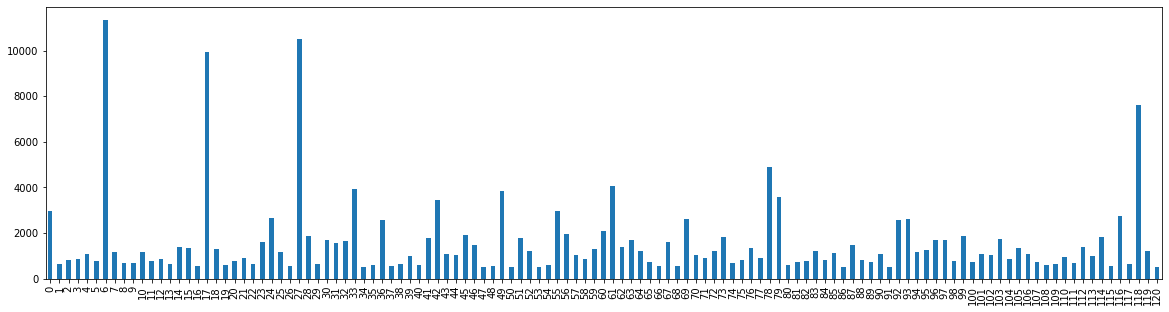

In [0]:
df_subcategs.groupby(['category']).size().reset_index(name='counts')['counts'].plot.bar(figsize=(20,5))

**Классификатор на представлении текста через TF-IDF**

In [0]:
CWByCategory_title, CWByCategory_content = FindMCWordsByCategory(df_categs,200,2500)

In [0]:
CWByCategory_content = set(CWByCategory_content)
CWByCategory_title = set(CWByCategory_title)

In [0]:
content = df_categs['content'].to_list()
titles = df_categs['titledesc'].to_list()

content_length = len(content)

WordsToSelect = CWByCategory_content
with concurrent.futures.ProcessPoolExecutor() as executor:
  r = list(tqdm.tqdm(executor.map(SelectWords, content), total=content_length))

df_categs['content'] = r

WordsToSelect = CWByCategory_title
with concurrent.futures.ProcessPoolExecutor() as executor:
  r = list(tqdm.tqdm(executor.map(SelectWords, titles), total=content_length))

df_categs['titledesc'] = r

100%|██████████| 222340/222340 [00:28<00:00, 7859.10it/s]


In [0]:
df_categs = df_categs[df_categs['titledesc']!='']
df_categs = df_categs[df_categs['content']!='']

df_categs = df_categs.reset_index(drop=True)

In [0]:
CWtitle, CWcontent = FindMCWords(df_categs,250,1000)

In [0]:
content = df_categs['content'].to_list()
titles = df_categs['titledesc'].to_list()

content_length = len(content)

WordsToDelete = CWcontent
with concurrent.futures.ProcessPoolExecutor() as executor:
  r = list(tqdm.tqdm(executor.map(DeleteWords, content), total=content_length))

df_categs['content'] = r

WordsToDelete = CWtitle
with concurrent.futures.ProcessPoolExecutor() as executor:
  r = list(tqdm.tqdm(executor.map(DeleteWords, titles), total=content_length))

df_categs['titledesc'] = r

100%|██████████| 192272/192272 [00:23<00:00, 8099.91it/s]


In [0]:
df_categs['titledesc'] = df_categs['titledesc'].apply(lambda row: ' '.join(list(set(row.split()))))
df_categs['content'] = df_categs['content'].apply(lambda row: ' '.join(list(set(row.split()))))

In [0]:
alexaWC_2 = df_categs[df_categs['content'].str.split().str.len() > 20]

In [0]:
y = alexaWC_2['category'].tolist()

df_train, df_test, y_train, y_test = train_test_split(alexaWC_2, y, test_size=0.25, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [0]:
idf_vectorizer1 = TfidfVectorizer()
idf_vectorizer3 = TfidfVectorizer()

countVectorizer1 = CountVectorizer()
countVectorizer3 = CountVectorizer()

idf_matrix1 = idf_vectorizer1.fit_transform(df_train[['category','titledesc']].groupby('category')['titledesc'].apply(lambda row: ' '.join(row)).reset_index(drop=True))
idf_matrix3 = idf_vectorizer3.fit_transform(df_train[['category','content']].groupby('category')['content'].apply(lambda row: ' '.join(row)).reset_index(drop=True))

count_matrix1 = countVectorizer1.fit_transform(df_train['titledesc'])
count_matrix3 = countVectorizer3.fit_transform(df_train['content'])

train_matrix1 = idf_matrix1 * count_matrix1.T
train_matrix3 = idf_matrix3 * count_matrix3.T

train_matrix = np.concatenate((train_matrix1.T.toarray(),train_matrix3.T.toarray()),axis=1)

count_matrix_test1 = countVectorizer1.transform(df_test['titledesc'])
count_matrix_test3 = countVectorizer3.transform(df_test['content'])

test_matrix1 = idf_matrix1 * count_matrix_test1.T
test_matrix3 = idf_matrix3 * count_matrix_test3.T

test_matrix = np.concatenate((test_matrix1.T.toarray(),test_matrix3.T.toarray()),axis=1)

In [0]:
X_train = train_matrix
X_test = test_matrix

In [0]:
len(set(y_train))

17

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

logreg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('ACCURACY :', accuracy_score(y_pred, y_test))
print('F1 :', f1_score(y_pred, y_test, average='macro'))

ACCURACY : 0.5901627052560546
F1 : 0.5802087901221973


In [0]:
y_pred = logreg.predict(X_train)
print('ACCURACY :', accuracy_score(y_pred, y_train))
print('F1 :', f1_score(y_pred, y_train, average='macro'))

ACCURACY : 0.5983920686495043
F1 : 0.5940303521711319




---



Поместил все проделанные выше действия в единую функцию для удобства вызова в юпитере

In [0]:
def TFIDFclassifier_V1(df_categor, titletake, contenttake, titledel, contentdel):
  df_categs1 = df_categor.copy()
  df_categs1['titledesc'] = df_categs1['titledesc'].apply(lambda row: ' '.join(list(set(row.split()))))
  df_categs1['content'] = df_categs1['content'].apply(lambda row: ' '.join(list(set(row.split()))))
#1
  CWByCategory_title, CWByCategory_content = FindMCWordsByCategory(df_categs1,titletake,contenttake)
  CWByCategory_content = set(CWByCategory_content)
  CWByCategory_title = set(CWByCategory_title)
  
  content = df_categs1['content'].to_list()
  titles = df_categs1['titledesc'].to_list()
  content_length = len(content)

  global WordsToSelect
  WordsToSelect = CWByCategory_content
  with concurrent.futures.ProcessPoolExecutor() as executor:
    r = list(tqdm.tqdm(executor.map(SelectWords, content), total=content_length))

  df_categs1['content'] = r

  WordsToSelect = CWByCategory_title
  with concurrent.futures.ProcessPoolExecutor() as executor:
    r = list(tqdm.tqdm(executor.map(SelectWords, titles), total=content_length))

  df_categs1['titledesc'] = r

  df_categs1 = df_categs1[df_categs1['titledesc']!='']
  df_categs1 = df_categs1[df_categs1['content']!='']
  df_categs1 = df_categs1.reset_index(drop=True)
#2
  CWtitle, CWcontent = FindMCWords(df_categs1,titledel,contentdel)
  CWtitle = set(CWtitle)
  CWcontent = set(CWcontent)
  content = df_categs1['content'].to_list()
  titles = df_categs1['titledesc'].to_list()

  content_length = len(content)

  global WordsToDelete
  WordsToDelete = CWcontent
  with concurrent.futures.ProcessPoolExecutor() as executor:
    r = list(tqdm.tqdm(executor.map(DeleteWords, content), total=content_length))

  df_categs1['content'] = r

  WordsToDelete = CWtitle
  with concurrent.futures.ProcessPoolExecutor() as executor:
    r = list(tqdm.tqdm(executor.map(DeleteWords, titles), total=content_length))

  df_categs1['titledesc'] = r

  df_categs1 = df_categs1[df_categs1['titledesc']!='']
  df_categs1 = df_categs1[df_categs1['content']!='']
  df_categs1 = df_categs1.reset_index(drop=True)
  print('DF Length: ',len(df_categs1))
#3
  alexaWC_2 = df_categs1[df_categs1['content'].str.split().str.len() > 10]
  alexaWC_2 = alexaWC_2[alexaWC_2['titledesc']!='']
  print('DF to train Length:',len(alexaWC_2))
  y = alexaWC_2['category'].tolist()

  df_train, df_test, y_train, y_test = train_test_split(alexaWC_2, y, test_size=0.25, random_state=42)
  df_train = df_train.reset_index(drop=True)
  df_test = df_test.reset_index(drop=True)
  print('y_train number:',len(set(y_train)))
#4
  idf_vectorizer1 = TfidfVectorizer()
  idf_vectorizer3 = TfidfVectorizer()

  countVectorizer1 = CountVectorizer()
  countVectorizer3 = CountVectorizer()

  idf_matrix1 = idf_vectorizer1.fit_transform(df_train[['category','titledesc']].groupby('category')['titledesc'].apply(lambda row: ' '.join(row)).reset_index(drop=True))
  idf_matrix3 = idf_vectorizer3.fit_transform(df_train[['category','content']].groupby('category')['content'].apply(lambda row: ' '.join(row)).reset_index(drop=True))

  count_matrix1 = countVectorizer1.fit_transform(df_train['titledesc'])
  count_matrix3 = countVectorizer3.fit_transform(df_train['content'])

  train_matrix1 = idf_matrix1 * count_matrix1.T
  train_matrix3 = idf_matrix3 * count_matrix3.T

  train_matrix = np.concatenate((train_matrix1.T.toarray(),train_matrix3.T.toarray()),axis=1)

  count_matrix_test1 = countVectorizer1.transform(df_test['titledesc'])
  count_matrix_test3 = countVectorizer3.transform(df_test['content'])

  test_matrix1 = idf_matrix1 * count_matrix_test1.T
  test_matrix3 = idf_matrix3 * count_matrix_test3.T

  test_matrix = np.concatenate((test_matrix1.T.toarray(),test_matrix3.T.toarray()),axis=1)

  X_train = train_matrix
  X_test = test_matrix

  print('Number of words title: ',len(set(CWByCategory_title)))
  print('Number of words content: ',len(set(CWByCategory_content)))
  print('Inputs: ',titletake, contenttake, titledel, contentdel)

  return X_train, X_test, y_train, y_test

Категории

In [0]:
X_train, X_test, y_train, y_test = TFIDFclassifier_V1(df_categs,100,1000,250,2000)

print('### Logreg: ###')
logreg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('ACCURACY :', accuracy_score(y_pred, y_test))
print('F1 :', f1_score(y_pred, y_test, average='macro'))
print(classification_report(y_test,y_pred))
print('X_train:')
y_pred = logreg.predict(X_train)
print('ACCURACY :', accuracy_score(y_pred, y_train))
print('F1 :', f1_score(y_pred, y_train, average='macro'))

100%|██████████| 186603/186603 [00:24<00:00, 7748.12it/s]


DF Length:  105463
DF to train Length: 52563
y_train number: 17
Number of words title:  769
Number of words content:  3213
Inputs:  100 1000 250 2000
### Logreg: ###
ACCURACY : 0.6214138954417472
F1 : 0.6199482430798808
              precision    recall  f1-score   support

           0       0.69      0.66      0.67      1283
           1       0.74      0.34      0.47       203
           2       0.67      0.64      0.66       796
           3       0.64      0.43      0.51       216
           4       0.49      0.31      0.38       640
           5       0.76      0.80      0.78       563
           6       0.61      0.70      0.65       948
           7       0.84      0.84      0.84       976
           8       0.84      0.83      0.83       560
           9       0.61      0.40      0.48       596
          10       0.68      0.55      0.60       626
          11       0.67      0.66      0.66       508
          12       0.58      0.62      0.60      1239
          13       0.74

Подкатегории

In [0]:
X_train, X_test, y_train, y_test = TFIDFclassifier_V1(df_subcategs,100,750,100,250)

print('### Logreg: ###')
logreg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('ACCURACY :', accuracy_score(y_pred, y_test))
print('F1 :', f1_score(y_pred, y_test, average='macro'))
print(classification_report(y_test,y_pred))
print('X_train:')
y_pred = logreg.predict(X_train)
print('ACCURACY :', accuracy_score(y_pred, y_train))
print('F1 :', f1_score(y_pred, y_train, average='macro'))

100%|██████████| 169699/169699 [00:22<00:00, 7631.07it/s]


DF Length:  155915
DF to train Length: 149897
y_train number: 121
Number of words title:  2653
Number of words content:  6863
Inputs:  100 750 100 250
### Logreg: ###
ACCURACY : 0.47874583055370246
F1 : 0.43111123117820493
              precision    recall  f1-score   support

           0       0.68      0.76      0.72       629
           1       0.25      0.12      0.16       125
           2       0.33      0.24      0.28       173
           3       0.54      0.55      0.54       170
           4       0.86      0.91      0.89       189
           5       0.36      0.38      0.37       149
           6       0.31      0.53      0.39      2406
           7       0.60      0.52      0.56       274
           8       0.36      0.13      0.19       131
           9       0.31      0.29      0.30       133
          10       0.19      0.06      0.10       250
          11       0.53      0.38      0.44       151
          12       0.27      0.16      0.20       178
          13       0

**Классификатор на FastText векторах**

Функция, которая удаляет самые популярные и самые редкие слова <br>
Проделанные выше действия, помещенные в функцию

In [0]:
def RemoveMostCommonWordsFromDF(df_categor, titletake, contenttake, titledel, contentdel):
  df_categs1 = df_categor.copy()
  df_categs1['titledesc'] = df_categs1['titledesc'].apply(lambda row: ' '.join(list(set(row.split()))))
  df_categs1['content'] = df_categs1['content'].apply(lambda row: ' '.join(list(set(row.split()))))
#1
  CWByCategory_title, CWByCategory_content = FindMCWordsByCategory(df_categs1,titletake,contenttake)
  CWByCategory_content = set(CWByCategory_content)
  CWByCategory_title = set(CWByCategory_title)
  
  content = df_categs1['content'].to_list()
  titles = df_categs1['titledesc'].to_list()
  content_length = len(content)

  global WordsToSelect
  WordsToSelect = CWByCategory_content
  with concurrent.futures.ProcessPoolExecutor() as executor:
    r = list(tqdm.tqdm(executor.map(SelectWords, content), total=content_length))

  df_categs1['content'] = r

  WordsToSelect = CWByCategory_title
  with concurrent.futures.ProcessPoolExecutor() as executor:
    r = list(tqdm.tqdm(executor.map(SelectWords, titles), total=content_length))

  df_categs1['titledesc'] = r

  df_categs1 = df_categs1[df_categs1['titledesc']!='']
  df_categs1 = df_categs1[df_categs1['content']!='']
  df_categs1 = df_categs1.reset_index(drop=True)
#2
  CWtitle, CWcontent = FindMCWords(df_categs1,titledel,contentdel)
  CWtitle = set(CWtitle)
  CWcontent = set(CWcontent)
  content = df_categs1['content'].to_list()
  titles = df_categs1['titledesc'].to_list()

  content_length = len(content)

  global WordsToDelete
  WordsToDelete = CWcontent
  with concurrent.futures.ProcessPoolExecutor() as executor:
    r = list(tqdm.tqdm(executor.map(DeleteWords, content), total=content_length))

  df_categs1['content'] = r

  WordsToDelete = CWtitle
  with concurrent.futures.ProcessPoolExecutor() as executor:
    r = list(tqdm.tqdm(executor.map(DeleteWords, titles), total=content_length))

  df_categs1['titledesc'] = r

  df_categs1 = df_categs1[df_categs1['titledesc']!='']
  df_categs1 = df_categs1[df_categs1['content']!='']
  df_categs1 = df_categs1.reset_index(drop=True)
#3
  ProcessedDF = df_categs1[df_categs1['content'].str.split().str.len() > 10]
  ProcessedDF = ProcessedDF[ProcessedDF['titledesc']!='']
  print('DF Length: ', len(ProcessedDF))
  return ProcessedDF

Функции преобразования текста в вектора

In [0]:
def text_to_vector(text):
  doc = [word for word in text.split() if word in fastext_vocab]
  
  if len(doc)!=0:
    return np.mean(model[doc],axis=0)
  else:
    return np.zeros((300,))

def text_to_idfWeightedVector(text):
  
  doc = []
  for word in text.split():
    doc.append(model[word] * idf_dict[word])

  return np.mean(doc, axis=0)

In [0]:
dfToClassifierCategs = RemoveMostCommonWordsFromDF(df_categs, 100,1000,250,750)
dfToClassifierSubcategs = RemoveMostCommonWordsFromDF(df_subcategs, 100,750,100,250)

100%|██████████| 186603/186603 [00:26<00:00, 7161.99it/s]


DF Length:  100219


100%|██████████| 169699/169699 [00:23<00:00, 7170.28it/s]


DF Length:  149897


**Классификатор на FastText через усрднение векторов**

Категории

In [0]:
print('To train length:',len(dfToClassifierCategs))
y = dfToClassifierCategs['category'].tolist()

content = dfToClassifierCategs['content'].to_list()
titles = dfToClassifierCategs['titledesc'].to_list()
content_length = len(content)

with concurrent.futures.ProcessPoolExecutor() as executor:
  a = list(tqdm.tqdm(executor.map(text_to_vector, titles), total=content_length))

with concurrent.futures.ProcessPoolExecutor() as executor:
  b = list(tqdm.tqdm(executor.map(text_to_vector, content), total=content_length))

X = np.concatenate((a,b),axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('y_train number:',len(set(y_train)))

To train length: 100219


100%|██████████| 100219/100219 [00:13<00:00, 7367.31it/s]


y_train number: 17


In [0]:
print('### Logreg: ###')
logreg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('ACCURACY :', accuracy_score(y_pred, y_test))
print('F1 :', f1_score(y_pred, y_test, average='macro'))
print(classification_report(y_test,y_pred))
print('X_train:')
y_pred = logreg.predict(X_train)
print('ACCURACY :', accuracy_score(y_pred, y_train))
print('F1 :', f1_score(y_pred, y_train, average='macro'))

### Logreg: ###


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


ACCURACY : 0.6187188185990821
F1 : 0.6229326776966575
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      2195
           1       0.61      0.48      0.54       362
           2       0.70      0.70      0.70      1070
           3       0.57      0.47      0.51       425
           4       0.55      0.43      0.48      1482
           5       0.75      0.81      0.78       719
           6       0.65      0.65      0.65      1850
           7       0.80      0.80      0.80      1631
           8       0.79      0.77      0.78       760
           9       0.60      0.50      0.55      1864
          10       0.62      0.57      0.59       790
          11       0.62      0.62      0.62       935
          12       0.59      0.62      0.60      2723
          13       0.59      0.62      0.61       189
          14       0.59      0.55      0.57       829
          15       0.56      0.54      0.55      2571
          16       0.55    

Подкатегории

In [0]:
print('To train length:',len(dfToClassifierSubcategs))
y = dfToClassifierSubcategs['category'].tolist()

content = dfToClassifierSubcategs['content'].to_list()
titles = dfToClassifierSubcategs['titledesc'].to_list()
content_length = len(content)

with concurrent.futures.ProcessPoolExecutor() as executor:
  a = list(tqdm.tqdm(executor.map(text_to_vector, titles), total=content_length))

with concurrent.futures.ProcessPoolExecutor() as executor:
  b = list(tqdm.tqdm(executor.map(text_to_vector, content), total=content_length))

X = np.concatenate((a,b),axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('y_train number:',len(set(y_train)))

To train length: 149897


100%|██████████| 149897/149897 [00:40<00:00, 3721.83it/s]


y_train number: 121


In [0]:
print('### Logreg: ###')
logreg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('ACCURACY :', accuracy_score(y_pred, y_test))
print('F1 :', f1_score(y_pred, y_test, average='macro'))
print(classification_report(y_test,y_pred))
print('X_train:')
y_pred = logreg.predict(X_train)
print('ACCURACY :', accuracy_score(y_pred, y_train))
print('F1 :', f1_score(y_pred, y_train, average='macro'))

### Logreg: ###


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


ACCURACY : 0.4444029352901935
F1 : 0.3935418487149269
              precision    recall  f1-score   support

           0       0.67      0.73      0.69       629
           1       0.17      0.12      0.14       125
           2       0.23      0.23      0.23       173
           3       0.49      0.48      0.48       170
           4       0.82      0.87      0.85       189
           5       0.30      0.28      0.29       149
           6       0.31      0.42      0.36      2406
           7       0.55      0.54      0.54       274
           8       0.27      0.17      0.21       131
           9       0.22      0.20      0.21       133
          10       0.16      0.05      0.07       250
          11       0.44      0.44      0.44       151
          12       0.22      0.17      0.19       178
          13       0.21      0.12      0.16       122
          14       0.41      0.41      0.41       293
          15       0.54      0.57      0.55       293
          16       0.28    

**Классификатор на FastText через умножение векторов слова на их idf значения документа и суммировании векторов**

Категории

In [0]:
print('To train length:',len(dfToClassifierCategs))
y = dfToClassifierCategs['category'].tolist()

idf_vectorizer1 = TfidfVectorizer()
idf_vectorizer3 = TfidfVectorizer()

df_grouped1 = dfToClassifierCategs[['category','titledesc']].groupby('category')['titledesc'].apply(lambda row: ' '.join(row)).reset_index(drop=True)
df_grouped3 = dfToClassifierCategs[['category','content']].groupby('category')['content'].apply(lambda row: ' '.join(row)).reset_index(drop=True)

idf_matrix1 = idf_vectorizer1.fit_transform(df_grouped1)
idf_matrix3 = idf_vectorizer3.fit_transform(df_grouped3)

tfidf_dict_title = dict(zip(idf_vectorizer1.get_feature_names(), idf_vectorizer1.idf_))
tfidf_dict_content = dict(zip(idf_vectorizer3.get_feature_names(), idf_vectorizer3.idf_))
print('dict length: ',len(tfidf_dict_title), len(tfidf_dict_content))

content = dfToClassifierCategs['content'].to_list()
titles = dfToClassifierCategs['titledesc'].to_list()
content_length = len(content)

idf_dict = tfidf_dict_title
with concurrent.futures.ProcessPoolExecutor() as executor:
  a = list(tqdm.tqdm(executor.map(text_to_idfWeightedVector, titles), total=content_length))

idf_dict = tfidf_dict_content
with concurrent.futures.ProcessPoolExecutor() as executor:
  b = list(tqdm.tqdm(executor.map(text_to_idfWeightedVector, content), total=content_length))

X = np.concatenate((a,b),axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('y_train number:',len(set(y_train)))

In [0]:
print('### Logreg: ###')
logreg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('ACCURACY :', accuracy_score(y_pred, y_test))
print('F1 :', f1_score(y_pred, y_test, average='macro'))
print(classification_report(y_test,y_pred))
print('X_train:')
y_pred = logreg.predict(X_train)
print('ACCURACY :', accuracy_score(y_pred, y_train))
print('F1 :', f1_score(y_pred, y_train, average='macro'))

Подкатегории

In [0]:
print('To train length:',len(dfToClassifierSubcategs))
y = dfToClassifierSubcategs['category'].tolist()

idf_vectorizer1 = TfidfVectorizer()
idf_vectorizer3 = TfidfVectorizer()

df_grouped1 = dfToClassifierSubcategs[['category','titledesc']].groupby('category')['titledesc'].apply(lambda row: ' '.join(row)).reset_index(drop=True)
df_grouped3 = dfToClassifierSubcategs[['category','content']].groupby('category')['content'].apply(lambda row: ' '.join(row)).reset_index(drop=True)

idf_matrix1 = idf_vectorizer1.fit_transform(df_grouped1)
idf_matrix3 = idf_vectorizer3.fit_transform(df_grouped3)

tfidf_dict_title = dict(zip(idf_vectorizer1.get_feature_names(), idf_vectorizer1.idf_))
tfidf_dict_content = dict(zip(idf_vectorizer3.get_feature_names(), idf_vectorizer3.idf_))
print('dict length: ',len(tfidf_dict_title), len(tfidf_dict_content))

content = dfToClassifierSubcategs['content'].to_list()
titles = dfToClassifierSubcategs['titledesc'].to_list()
content_length = len(content)

idf_dict = tfidf_dict_title
with concurrent.futures.ProcessPoolExecutor() as executor:
  a = list(tqdm.tqdm(executor.map(text_to_idfWeightedVector, titles), total=content_length))

idf_dict = tfidf_dict_content
with concurrent.futures.ProcessPoolExecutor() as executor:
  b = list(tqdm.tqdm(executor.map(text_to_idfWeightedVector, content), total=content_length))

X = np.concatenate((a,b),axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('y_train number:',len(set(y_train)))

In [0]:
print('### Logreg: ###')
logreg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('ACCURACY :', accuracy_score(y_pred, y_test))
print('F1 :', f1_score(y_pred, y_test, average='macro'))
print(classification_report(y_test,y_pred))
print('X_train:')
y_pred = logreg.predict(X_train)
print('ACCURACY :', accuracy_score(y_pred, y_train))
print('F1 :', f1_score(y_pred, y_train, average='macro'))

К сожалению, модель не успела обучиться, гугл коллаб выключил рантайм<br>
Примерная точность в F1, которая была в прошлые разы:<br>
На категориях: test - 0,59 train - 0,62 <br>
На подкатегориях: test - 0,41 train - 0,47